# Notebook 18: Finite strain

For finite strain (strain > 1%), we can also compute the displacement gradient tensor $e_{ij}$ from the displacement of stations. However in this case, there are two states, the undeformed and deformed one, and we need to decide in which one we want to compute strain. In this notebook, we will compute strain in the deformed configuration.

From the displacement gradient in the deformed configuration, $\bar{e}_{i j}$, we can calculate the Eulerian finite strain tensor, $\bar{E}_{i j}$:

$$
\bar{E}_{i j}=\frac{1}{2}\left[\frac{\partial u_i}{\partial x_j}+\frac{\partial u_j}{\partial x_i}-\frac{\partial u_k}{\partial x_i} \frac{\partial u_k}{\partial x_j}\right]=\frac{1}{2}\left[\bar{e}_{i j}+\bar{e}_{j i}-\bar{e}_{k i} \bar{e}_{k j}\right]
$$

And from $\bar{E}_{i j}$, we can calculate the principal strains, and strain measurements such as dilatation ($S_1*S_2*S_3$) and maximum shear strain (if plane strain).

## Python functions

1. The function [fin_strain](../functions/fin_strain.py) computes the finite strain from the displacement gradient in either the undeformed or deformed configuration.

2. The function [grid_fin_strain](../functions/grid_fin_strain.py) works similarly to the corresponding function for infinitesimal strain. It calculates the strain in a grid of triangles or rectangles. In the rectangular grid, it uses either the nearest neighbor or weighted distance routines.

## Application

Let's look at the finite strain in a discrete element simulation. The file [FTB.txt](../data/FTB.txt) contains the layer id (column 1), initial coordinates (columns 2 and 3), displacements (columns 4 and 5), and radii (column 6) of circular elements in a discrement element model (DEM) of a fold and thrust belt. 

The DEM is a numerical technique to simulate tectonic deformation. In this technique, the rock is represented by an assembly of rigid circular elements in 2D or spheres in 3D. The elements interact under gravity, contact forces, and boundary displacements.

The data for this notebook is from a 2D simulation produced with the program cdem2D by Stuart Hardy ([Cardozo and Hardy, 2023](https://pubs.geoscienceworld.org/gsa/geosphere/article/19/5/1259/627588/cdem-A-macOS-program-for-discrete-element-modeling)). Let's plot the deformed configuration:

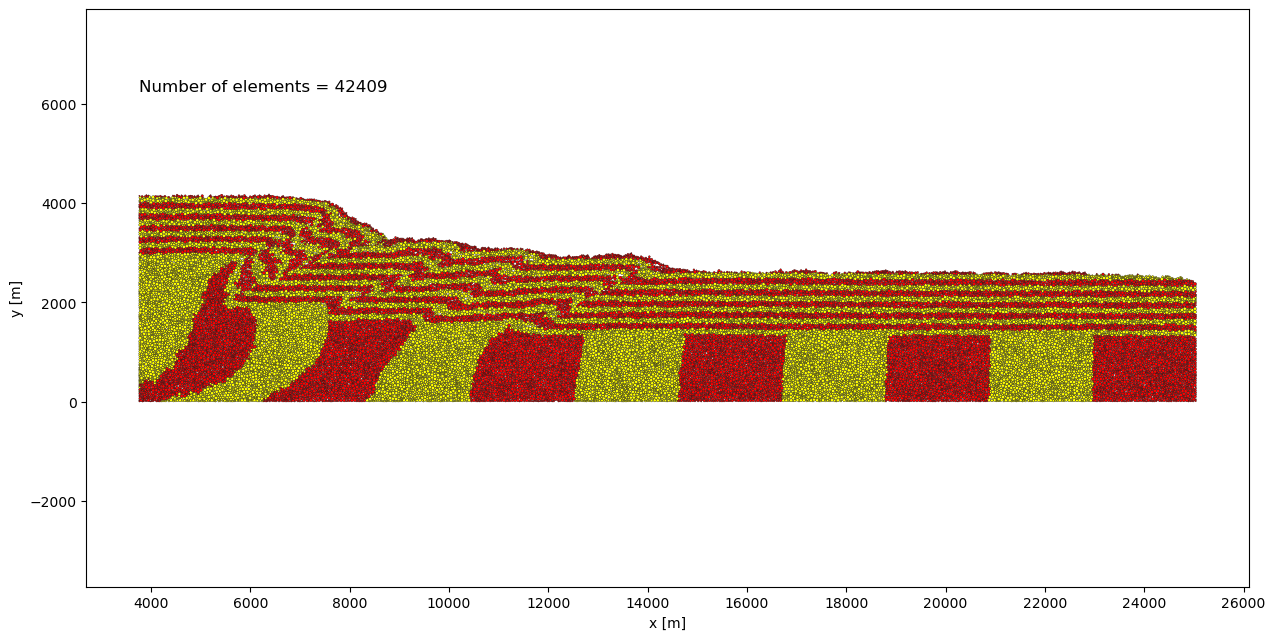

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# read the data in FTB.txt
ftb = np.loadtxt(os.path.join("..", "data", "FTB.txt"))

# coordinates are initial but make them final
ftb[:, 1] = ftb[:, 1] + ftb[:, 3]
ftb[:, 2] = ftb[:, 2] + ftb[:, 4]

# create a figure and axis
fig, ax = plt.subplots(figsize=(15,7.5))

# axes limits
xlim = (min(ftb[:, 1]), max(ftb[:, 1]))
ylim = (min(ftb[:, 2]), max(ftb[:, 2]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# get the axis scaling (data units to points conversion factor)

# calculate data range to points ratio for both axes
x_range = xlim[1] - xlim[0]  # x-axis
y_range = ylim[1] - ylim[0] # y-axis

# figure size in points
fig_width, fig_height = fig.get_size_inches() * fig.dpi  

# calculate the scaling factor to convert radius in data units to points²
scaling_factor_x = fig_width / x_range  # Points per data unit in x-direction
scaling_factor_y = fig_height / y_range  # Points per data unit in y-direction

# use the smaller of both scaling factors
scaling_factor = min(scaling_factor_x, scaling_factor_y)

# split the data into two arrays, ftb_1 and ftb_2
ftb_1 = ftb[ftb[:, 0] == 1]
ftb_2 = ftb[ftb[:, 0] == 2]

# plot ftb_1 in yellow
sizes = (ftb_1[:,5] * scaling_factor) ** 2
ax.scatter(ftb_1[:, 1], ftb_1[:, 2], s=sizes, c="yellow", edgecolor="black", linewidth=0.25)
# plot ftb_2 in red
sizes = (ftb_2[:,5] * scaling_factor) ** 2
ax.scatter(ftb_2[:, 1], ftb_2[:, 2], s=sizes, c="red", edgecolor="black", linewidth=0.25)
# number of elements
ax.text(xlim[0], ylim[1]*1.5, f"Number of elements = {len(ftb)}", fontsize=12)

# make the axes equal
ax.axis("equal")
# axes ticks every tick_spacing units
tick_spacing = 2000
ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
# axes labels
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

plt.show()

The figure shows a fold and thrust belt (thin horizontal layers) whose substrate (thick vertical layers) is a rock material with viscous behavior (e.g., salt). Now let's compute the finite strain. We could use the [grid_fin_strain](../functions/grid_fin_strain.py) function, but instead we will compute the strain in each element from the number of elements within a radius, $r$, equal to twice the maximum radius of the elements. We color the elements by the maximum shear strain. Running this code takes some time (in my computer 15 sec). After all, you will be computing the strain of 42,000 elements!

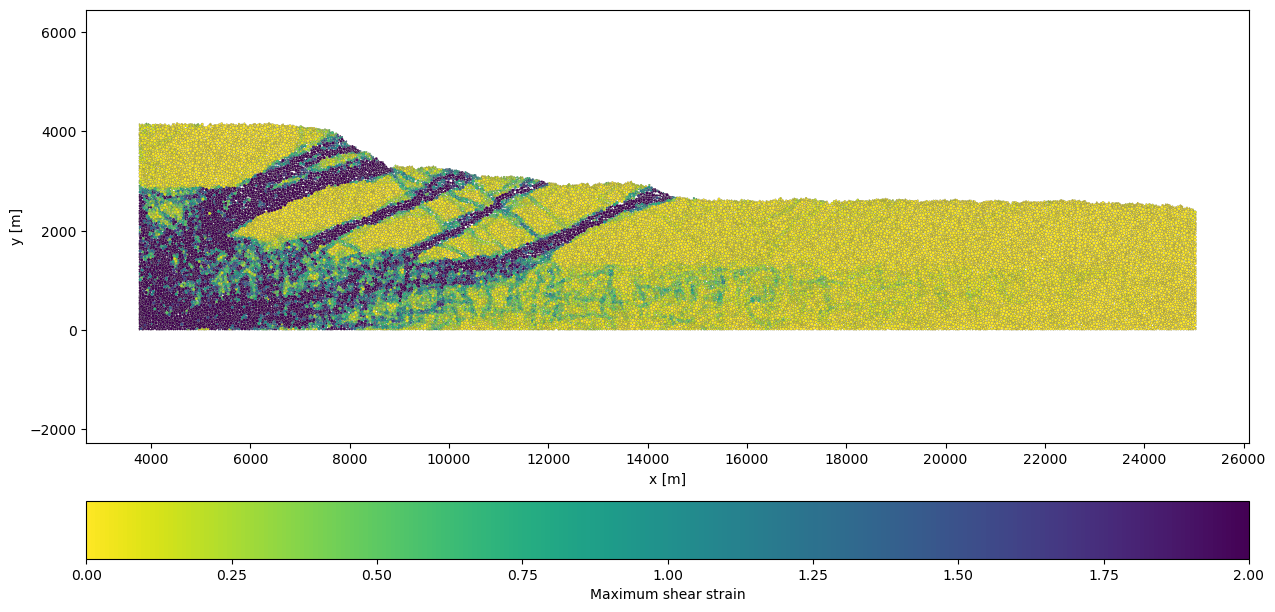

In [2]:
# this makes visible our functions folder
sys.path.append(os.path.abspath(os.path.join("..", "functions")))

# import lscov and fin_strain functions
from lscov import lscov
from fin_strain import fin_strain

# radius to search elements
max_radius = max(ftb[:, 5])
r = max_radius * 2.0

# finite strain at the elements
strain = np.zeros(len(ftb))

# loop over the elements
for i, element in enumerate(ftb):
    # get the coordinates of the element
    x, y = element[1], element[2]
    # get the elements in the neighborhood
    neighborhood = ftb[(ftb[:, 1] - x)**2 + (ftb[:, 2] - y)**2 < r**2]
    # calculate the strain if at least 3 elements are in the neighborhood
    n = len(neighborhood)
    if n >= 3:
        # calculate the displacement gradient tensor
        # Eqs. 2 to 4 in notebook 17
        # initialize arrays
        y = np.zeros(n*2) # displacement column vector
        M = np.zeros((n*2,6)) # design matrix
        e = np.zeros((3,3)) # displacement gradient tensor
        # In fin_strain, angles are measured in a NED 
        # coordinate system. Thus X1 = y and X2 = x coordinates
        for j in range(n):
            # displacement column vector
            y[j*2] = neighborhood[j,4] # y displacement
            y[j*2+1] = neighborhood[j,3] # x displacement
            # design matrix: y and x coordinates
            M[j*2,:] = [1.,0.,neighborhood[j,2],neighborhood[j,1],0.,0.]
            M[j*2+1,:] = [0.,1.,0.,0.,neighborhood[j,2],neighborhood[j,1]]
            # Find x using function lscov
            x = lscov(M,y)
        # displacement gradient tensor
        for j in range(2):
            e[j,0] = x[j*2+2]
            e[j,1] = x[j*2+3]
        # compute maximum shear strain from displacement gradient tensor
        _, _, _, maxsh = fin_strain(e,1)
        strain[i] = maxsh[0]

# plot the elements and color them by the strain
fig, ax = plt.subplots(figsize=(15,7.5))

# axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# plot the elements
sizes = (ftb[:,5] * scaling_factor) ** 2
cbar = ax.scatter(ftb[:, 1], ftb[:, 2], s=sizes, c=strain, cmap="viridis_r", edgecolor="black", linewidth=0.1)
# set the limits of the colorbar to 0.0 and 2.0
cbar.set_clim(0.0, 2.0)
# add a colorbar to the bottom of the plot
cbar = fig.colorbar(cbar, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("Maximum shear strain")

# make the axes equal
ax.axis("equal")
# axes ticks every tick_spacing units
tick_spacing = 2000
ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
# axes labels
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

plt.show()

There you have. Finite strain in a DEM 🙂